# Heuristics Lab
The goal of this lab is to gain experience using heuristics in tandem with other algorithms.

For the purposes of this assignment, you will be implementing a solver for the "2048" game (whose implementation will already be given to you). Before continuing, the following cell contains any dependencies you may need for this assignment: 

In [29]:
import matplotlib.pyplot as plt

from game import *

You should also look at `game.py` to understand how the in-line version has been implemented. 

## Background Info

2048 is a single-player sliding block puzzle game played on a 4x4 grid where tiles containing even numbers can be moved around and merged to create larger numbers. If this does not ring a bell, it is highly recommended that you play the game at some point (enjoy the cupcake version [here](https://0x0800.github.io/2048-CUPCAKES/)).

While the implementation has been given, ensure that you understand what a tile, a turn, a legal move, and when the game ends is.

This particular implementation/walk through focuses on utilization of heuristic functions themselves (or strategies that are simple enough that a human player could follow them) & only looks ahead by 1 move (as opposed to adding this heuristic into another algorithm like nimimax or expectimax - which would yield better results)

Questions: 
1. What is a potential representation of the solution space?
2. How can you evaluate the results of a single move? 
3. How might you select and combine heuristics?
4. How can you evaluate the results of an entire game?


## A. Assessing the Problem

What is a potential representation of the solution space?

- Single Solution = one sequence of moves (up, down, left, right)
- Solution Space = all possible sequences of moves that could be played in a game of 2048

Play a SINGLE round of 2048 (you can do this on the website with the nice UI instead of the text version). What score did you get?

![2048](./assets/img1.png)


## B. Evaluating a Single Move

Before implementing specific heuristics, a general implementation procedure must be formed.

Use the following pseudocode to write a function to evaluate a game _G_ in its current state:

**Input:** _G_ - a game, _M_ - a set of moves \
**Output:** The best moves according to the specific evaluator

**procedure** EvaluateGame(_G_, _M_)\
&emsp;_bestScore_ ← −1\
&emsp;_bestMoves_ ← ∅\
&emsp;**for all** _move_ ∈ _M_ **do**\
&emsp;&emsp;_G'_ ← _G_\
&emsp;&emsp;apply _move_ to _G'_\
&emsp;&emsp;_curScore_ ← the score given by the evaluator’s specific criteria\
&emsp;&emsp;**if** _curScore_ > _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestScore_ ← _curScore_\
&emsp;&emsp;&emsp;_bestMoves_ ← {_move_}\
&emsp;&emsp;**else if** _curScore_ = _bestScore_ **then**\
&emsp;&emsp;&emsp;_bestMoves_ ← _bestMoves_ ∪ {_move_}\
&emsp;&emsp;**end if**\
&emsp;**end for**\
&emsp;return _bestMoves_\
**end procedure**

For now, use the overall game score as the evaluation criteria. Remember to consider how the game/board is referenced when running each move.

In [30]:
def evaluate_game(game, moves):
    best_score = -1
    best_moves = set()
    for move in moves:
        game_copy = game.copy()
        if game_copy.play_turn(move):
            current_score = game_copy.score
            if current_score > best_score:
                best_score = current_score
                best_moves = {move}
            elif current_score == best_score:
                best_moves.add(move)
    return best_moves

## C. Selecting Heuristics

### Refactoring Evaluation

At this point in time, the solver uses a 'greedy' heuristic of purely selecting tiles based on the highest immediate increase to score.  Before we try other heuristics, let's refactor the `evaluate_move()` function to take in a heuristic function instead of hardcoding the evaluator's criteria. 

After updating the function, it can be tested with the given `game_score()` heuristic function.

In [31]:
def game_score(game):
    return game.score

def evaluate_game (game, moves, heuristic): 
    best_score = -1
    best_moves = set()
    for move in moves:
        game_copy = game.copy()
        if game_copy.play_turn(move):
            current_score = heuristic(game_copy)
            if current_score > best_score:
                best_score = current_score
                best_moves = {move}
            elif current_score == best_score:
                best_moves.add(move)
    return best_moves

We should also define a random move selection function as a groud zero/baseline point of comparison.

In [32]:
def random_move(moves):
    return random.choice(list(moves))

### Various Heuristics

There are multiple heuristics that can be used to solve a 2048 game: 
- Greedy - approximates in-game score after each move & return the one with the highest result
- Monotincity - values are either non-increasing or non-decreasing along all rows and non-increasing or non-decreasing along all columns
- Empty - prioritizes moves that increases the # of empty tiles on the board
- Smoothness - keeps tiles of similar value close to each other
- Weight matrix - a grid w higher weighting tiles on one part of the grid (resulting in higher utility & the algorithm shifting tiles/converging them on one corner of weights)

Pick two heuristics (other than greedy - which you already did) & write functions calculating those. You may choose another heuristic that is not on this list if you would prefer that.

In [33]:
def empty_tiles_heuristic(game):
    """
    Evaluates a game state by counting the number of 
    empty tiles, aiming to provides more flexibility.
    """
    return np.count_nonzero(game.board == 0)

def weight_matrix_heuristic(game):
    """
    Evaluates a game state using a weight matrix,
    where high-value tiles are in the top-right corner.
    """
    weight_matrix = np.array([
        [1, 2, 4, 8],
        [1, 2, 4, 4],
        [1, 1, 2, 2],
        [1, 1, 1, 1]
    ])
    return np.sum(game.board * weight_matrix)

## D. Evaluating a Game

### Making the Solver

Now that value has successfully been equated to the outcome of a single move, this needs to be done on the entire game. 

To start, your solver should take in a game and a heuristic to abide by. 

Most heuristic evaluators are non-terminal, meaning they will return more than one possible move of equal value. In order to combat this, a terminal evaluator must be included in the overall game solver to ensure only one move is selected. This can be done by randomly selecting from the list of "best moves" provided by the heuristic. 

In [34]:
def run_solver(game, heuristic):
    moves = ['w', 'a', 's', 'd']
    while game.has_valid_moves():
        best_moves = evaluate_game(game, moves, heuristic)
        if not best_moves:
            break
        selected_move = random.choice(list(best_moves))
        game.play_turn(selected_move)
    print("Final Score: ", game.score)
    game.display()
    return game.score

Run the following cell to test your solver on just the `game_score` heuristic:

In [35]:
g = Board()
run_solver(g, game_score)

Final Score:  944
Score: 944
[[64  2  4  8]
 [ 2 16  8  2]
 [16 32 64  8]
 [ 4  8 16  2]]


np.int64(944)

Try the full game solver on some of your other heuristics. Note that sometimes they will flatline or get stuck in a pattern of moves that do not appear to converge in a termination point.

In [36]:
g = Board()
run_solver(g, weight_matrix_heuristic)

KeyboardInterrupt: 

#### Resolving Flatlining

One way to resolve flatlining is to to update the solver to count for a certain number of repeating moves and reintroduce a random selection.

In [37]:
def run_solver(game, heuristic): 
    threshold = 7
    previous_move = None
    repeat_count = 0
    moves = ['w', 'a', 's', 'd']
    while game.has_valid_moves():
        best_moves = evaluate_game(game, moves, heuristic)
        if not best_moves:
            break
        if repeat_count >= threshold:
            selected_move = random.choice(moves)
            repeat_count = 0
        else:
            selected_move = random.choice(list(best_moves))
        
        if selected_move == previous_move:
            repeat_count += 1
        else:
            repeat_count = 0    
        previous_move = selected_move

        game.play_turn(selected_move)
    print("Final Score: ", game.score)
    game.display()
    return game.score

g = Board()
run_solver(g, weight_matrix_heuristic)

Final Score:  2920
Score: 2920
[[  4  32  64 256]
 [  2  16  32  64]
 [  4   8  16  32]
 [ 16   2   4  16]]


np.int64(2920)

#### Combining Heuristics 

A simple way to incorporate multiple heuristics is to create a `combined_heuristic()` function that assigns weights to various heuristics. These weights can also help offset any discrepancies in the scale of resulting "scores".

The combined score should be calculated by multiplying the weight of an individual heuristic's score with its score.

In [38]:
def combined_heuristic(game):
    empty_score = empty_tiles_heuristic(game)
    weight_score = weight_matrix_heuristic(game)

    # Assign weights to each heuristic
    empty_tiles_weight = 100
    weight_matrix_weight = 1
    # Combine heuristics
    combined_score = empty_tiles_weight * empty_score + weight_matrix_weight * weight_score

    return combined_score

g = Board()
run_solver(g, combined_heuristic)


Final Score:  2024
Score: 2024
[[  2  16  64   2]
 [  4  64 128  32]
 [  8  32  64   8]
 [  2   8   2   4]]


np.int64(2024)

### Plotting Results

Run 100 cycles of each of your heuristics & plot your results. You should have at least 3 lines (score, your heuristic #1, your heuristic #2, and potentially a completely random implementation)

In [39]:
def random_heuristic(game):
    return random.randint(0, 100)

In [ ]:
heuristics = [
    ['Game Score', game_score, []],
    ['Empty Tiles', empty_tiles_heuristic, []],
    ['Weight Matrix', weight_matrix_heuristic, []],
    ['Combined', combined_heuristic, []],
    ['Random', random_heuristic, []],
]

for _ in range(100):
    for heuristic_data in heuristics:
        name, heuristic, results_list = heuristic_data
        g = Board()
        # Run your solvers here
        score = run_solver(g, heuristic)
        results_list.append(score)

Final Score:  1180
Score: 1180
[[  2   8  16   2]
 [  4  32 128   8]
 [  8  16  32  16]
 [  4   8   4   2]]
Final Score:  1688
Score: 1688
[[  8  64   4   2]
 [  4 128  32   8]
 [  8  64   8   4]
 [  2  32   4   2]]
Final Score:  2316
Score: 2316
[[  4   8  64 256]
 [  2   4  32  16]
 [  8   2  16   4]
 [  2   4   8   2]]
Final Score:  2264
Score: 2264
[[  2   4  64 128]
 [  4  64 128   8]
 [  2   4  32   2]
 [  8   2   4   8]]
Final Score:  744
Score: 744
[[ 2 32  2  8]
 [ 4 64  8  2]
 [16 32 16  8]
 [ 2 16  8  2]]
Final Score:  1384
Score: 1384
[[  2   4   2   4]
 [ 16 128   8  16]
 [  2  32  64   8]
 [ 16   8  16   2]]
Final Score:  1536
Score: 1536
[[  2  32   4   2]
 [  4  64 128   8]
 [ 16  32  16   4]
 [  2   4  32   2]]
Final Score:  3272
Score: 3272
[[  4  32  64 256]
 [ 16   8  32 128]
 [  2   4  16  32]
 [  8   2   4   2]]
Final Score:  3108
Score: 3108
[[  2   8 128   2]
 [ 16  64  32 256]
 [  8  16   8   2]
 [  2   4   2  16]]
Final Score:  692
Score: 692
[[ 2 16 32  4]
 [

/var/folders/3_/5dvts2vs4s1bdt0tz8nb_y900000gn/T/ipykernel_44575/980238779.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([h[2] for h in heuristics], labels=[h[0] for h in heuristics])


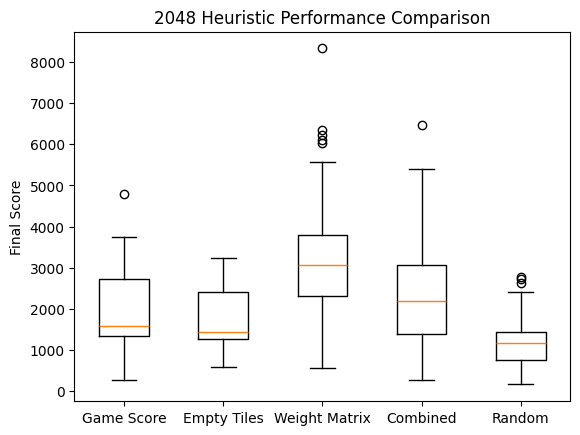

In [ ]:
plt.boxplot([h[2] for h in heuristics], labels=[h[0] for h in heuristics])
plt.ylabel('Final Score')
plt.title('2048 Heuristic Performance Comparison')
plt.show()

From the graph, we conclude that organizing the tiles, like concentrating in a corner, is more effective than maintaining board flexibility or attempting to maximizing score incrementally. We can also see that all strategic approaches achieve significantly higher score than the base (random) heuristic. The performance on the boxplot suggests that Weight Matrix heuristic is the most effective strategy among the ones that were implemented for this 2048 game assignment.

_I loved playing 2048 (spent almost 40 minutes doing so in the beginning of the assignment)._

Just in case the values change, the following cell contains the code to generate the graph.

![2048](./assets/output.png)